# Push and pop test

Test how fast it is to push and pop items from a `Vector()` and a `Set()`

**Bottom line:** for this kind of work `Set()` is far more optimal!

In [1]:
using Pkg
# Pkg.activate(".")
using Random
using BenchmarkTools

In [2]:
coll_size = 500

500

In [6]:
testv = collect(1:coll_size)
shuffle!(testv)

500-element Vector{Int64}:
 446
  15
  67
  93
 131
 238
 500
 471
 274
 423
   ⋮
 155
 370
  23
 384
 330
 383
 279
 377
  49

In [7]:
@benchmark begin
    v1 = copy($(testv))
    for i in 1:coll_size
        ind = indexin(i, v1)
        deleteat!(v1, ind[1])
    end
end

BenchmarkTools.Trial: 2391 samples with 1 evaluation.
 Range (min … max):  1.407 ms …   4.268 ms  ┊ GC (min … max):  0.00% … 53.08%
 Time  (median):     1.805 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.091 ms ± 646.488 μs  ┊ GC (mean ± σ):  15.94% ± 20.04%

           █▇                                                  
  ▂▃▃▃▃▃▃▄████▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▂▂▂▂ ▃
  1.41 ms         Histogram: frequency by time        3.69 ms <

 Memory estimate: 8.58 MiB, allocs estimate: 6842.

In [34]:
"""Test performance of popping from a Vector"""
####
# Cannot get this to work, as @benchmark does not inherit the local context
# from the function, so it cannot find the `this_v2` Vector
####
function test_vector(coll_size::Int)
    # Setup a random ordered array of 
    this_v2 = collect(1:coll_size)
    shuffle!(this_v2)
    println(length(this_v2))

    # Now benckmark deleting the collection, by element value
    @benchmark begin
        setup=(copy_v = copy($this_v2)) 
        evals=1
        for i in 1:coll_size
            ind = indexin(i, copy_v)
            deleteat!(copy_v, ind[1])
        end
    end
end

test_vector

## Vector `deleteat!` timing

This is how to solve it, define what is needed globally, but ensure that the correct global values get copied into the benchmark context, using the context references `$(this_v)` and `$(coll_size)`

In [4]:
coll_sizes = [5, 10, 50, 100, 500, 1000]
trial_v = Vector{BenchmarkTools.Trial}()
for coll_size in coll_sizes
    this_v = collect(1:coll_size)
    shuffle!(this_v)
    println(length(this_v))

    # Now benckmark deleting the collection, by element value
    res = @benchmark begin
        setup=(copy_v = copy($this_v); v_size=$(coll_size))
        for i in 1:v_size
            ind = indexin(i, copy_v)
            deleteat!(copy_v, ind[1])
        end
    end
    push!(trial_v, res)
end

5


10


50


100


500


1000


In [8]:
time_v = Float64[]
for trial in trial_v
    push!(time_v, median(trial).time)
    println(median(trial).time)
end

573.7043010752689
1291.7
21125.0
79708.0
1.8266045e6
9.2163335e6


In [9]:
trial_s = Vector{BenchmarkTools.Trial}()
for coll_size in coll_sizes
    this_s = Set(1:coll_size)
    println(length(this_s))

    # Now benckmark deleting the collection, by element value
    res = @benchmark begin
        setup=(copy_s = copy($this_s); s_size=$(coll_size))
        for i in 1:s_size
            delete!(copy_s, i)
        end
    end
    push!(trial_s, res)
end

5


10


50


100


500


1000


In [10]:
time_s = Float64[]
for trial in trial_s
    push!(time_s, median(trial).time)
    println(median(trial).time)
end

57.8253807106599
67.96935648621042
240.437125748503
581.2272727272727
2512.5
4869.875


In [27]:
# N.B. Cannot be "using" CairoMakie and Plots in the same session - they define the same
# things in the global namespace (could use "import", if one really did want to have them both)
using CairoMakie


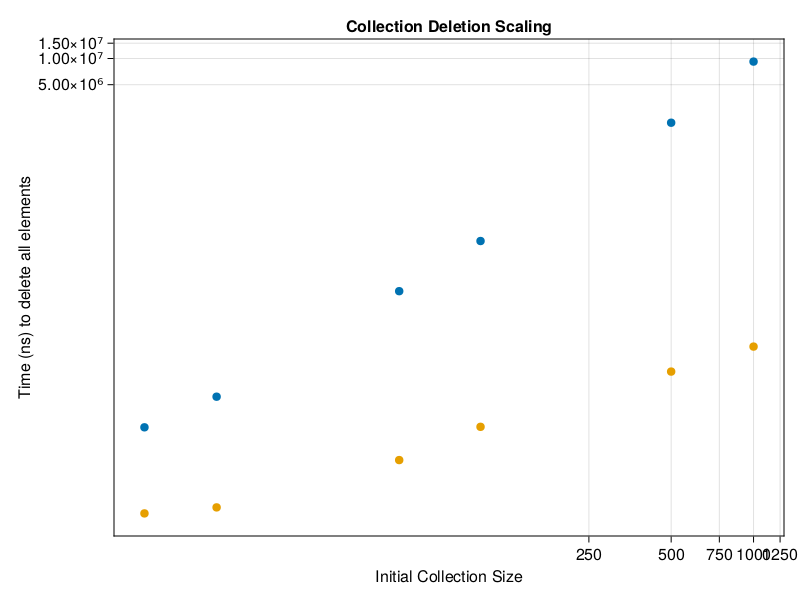

In [21]:
f = Figure()
ax = Axis(f[1, 1], title="Collection Deletion Scaling", 
    xlabel="Initial Collection Size", ylabel="Time (ns) to delete all elements", 
    yscale = Makie.pseudolog10, xscale=Makie.pseudolog10)
scatter!(ax, coll_sizes, time_v)
scatter!(ax, coll_sizes, time_s)
f

In [18]:
scatter!(ax, coll_sizes, time_v)
scatter!(ax, coll_sizes, time_s)

Scatter{Tuple{Vector{Point{2, Float32}}}}

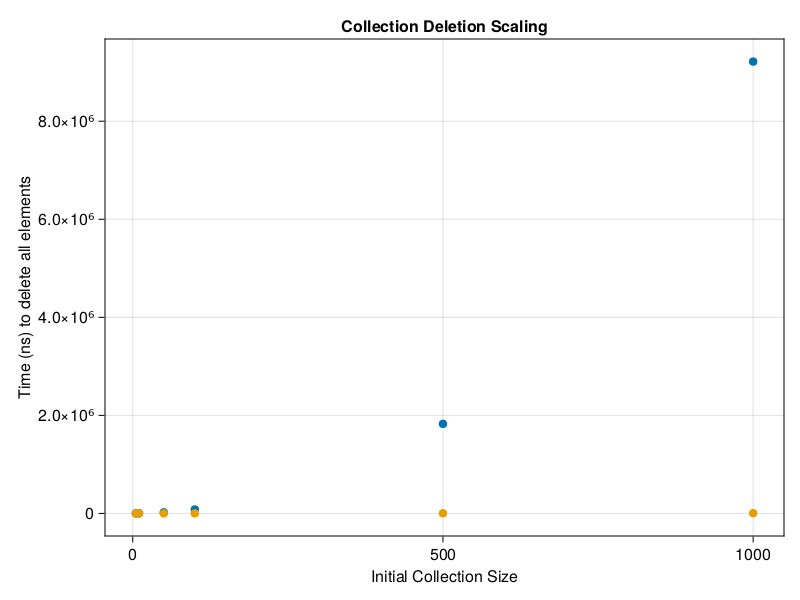

In [19]:
f